## Import AQS Data

In [1]:
import os
import pandas as pd

# Directory containing the CSV files
data_dir = "AQS_pm2.5"

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all files in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_dir, file_name)
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_data = pd.concat(dataframes, ignore_index=True)

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/3354360027.py:15: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/3354360027.py:15: DtypeWarning: Columns (13,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [2]:
# Load the CSV file into a DataFrame
file_path = 'AQS_data_2016/PM25_TOT_d02_WHbase_2016_1_EPA_CMAQ_Combine.csv'
df_cmaq_baseline = pd.read_csv(file_path)

file_path = 'AQS_data_2016/PM25_TOT_d02_WHbase_2016_1_EPA_CMAQ_Combine_2020_RWC.csv'
df_cmaq_2020 = pd.read_csv(file_path)

## Filter for site numbers consistent across the years

In [3]:
### create dt columns 

# Convert 'Date Local' to datetime
combined_data['Date Local'] = pd.to_datetime(combined_data['Date Local'])

# Extract year and month for filtering
combined_data['Year'] = combined_data['Date Local'].dt.year
combined_data['Month'] = combined_data['Date Local'].dt.month

df_cmaq_2020.loc[:,'Year'] = (pd.to_datetime(df_cmaq_2020['dt'])).dt.year
df_cmaq_baseline.loc[:,'Year'] = (pd.to_datetime(df_cmaq_baseline['dt'])).dt.year

In [4]:
### Create a unique site identifier

combined_data['Site ID'] = (
    combined_data['State Code'].astype(str) + "-" +
    combined_data['County Code'].astype(str) + "-" +
    combined_data['Site Num'].astype(str)
)

df_cmaq_baseline['Site ID'] = (
    df_cmaq_baseline['State Code'].dropna().astype(int).astype(str) + "-" +
    df_cmaq_baseline['County Code'].dropna().astype(int).astype(str) + "-" +
    df_cmaq_baseline['Site Num'].dropna().astype(int).astype(str)
)

df_cmaq_2020['Site ID'] = (
    df_cmaq_2020['State Code'].dropna().astype(int).astype(str) + "-" +
    df_cmaq_2020['County Code'].dropna().astype(int).astype(str) + "-" +
    df_cmaq_2020['Site Num'].dropna().astype(int).astype(str)
)



len(combined_data['Site ID'].unique())

1527

In [58]:
#### FILTERING FOR COMMON SITES

# Get the count of unique years for each site
site_year_counts = combined_data.groupby('Site ID')['Year'].nunique()

# Find sites present in all years
common_sites = site_year_counts[site_year_counts == combined_data['Year'].nunique()].index


filtered_data = combined_data[combined_data['Site ID'].isin(common_sites)]
filtered_cmaq_baseline = df_cmaq_baseline[df_cmaq_baseline['Site ID'].isin(common_sites)]
filtered_cmaq_2020 = df_cmaq_2020[df_cmaq_2020['Site ID'].isin(common_sites)]

data_lost =round( 100 * (combined_data.shape[0] - filtered_data.shape[0])/ combined_data.shape[0] , 2)
print(f"Data lost from filtering {data_lost}%")

Data lost from filtering 50.01%


In [71]:
filtered_data.loc[filtered_data['Sample Duration'] == "1 HOUR"][['Sample Duration','Local Site Name', 'Date Local']]

,Sample Duration,Local Site Name,Date Local
2922,1 HOUR,GARDEN/TRINITY CHRISTIAN CHURCH,2019-01-01
2923,1 HOUR,GARDEN/TRINITY CHRISTIAN CHURCH,2019-01-02
2924,1 HOUR,GARDEN/TRINITY CHRISTIAN CHURCH,2019-01-03
2925,1 HOUR,GARDEN/TRINITY CHRISTIAN CHURCH,2019-01-04
2926,1 HOUR,GARDEN/TRINITY CHRISTIAN CHURCH,2019-01-05
...,...,...,...
7323158,1 HOUR,Pinedale Gaseous,2017-12-27
7323159,1 HOUR,Pinedale Gaseous,2017-12-28
7323160,1 HOUR,Pinedale Gaseous,2017-12-29
7323161,1 HOUR,Pinedale Gaseous,2017-12-30


In [18]:
### DAY NIGHT FILTERING

filtered_cmaq_2020['dt'] = pd.to_datetime(filtered_cmaq_2020['dt'])
filtered_cmaq_2020['hour'] = filtered_cmaq_2020['dt'].dt.hour
filtered_cmaq_baseline['dt'] = pd.to_datetime(filtered_cmaq_baseline['dt'])
filtered_cmaq_baseline['hour'] = filtered_cmaq_baseline['dt'].dt.hour
day_bound = 6
night_bound = 17

df_day_2020 = filtered_cmaq_2020.loc[(filtered_cmaq_2020['hour'] >= day_bound) & (filtered_cmaq_2020['hour'] <= night_bound)]
df_night_2020 = filtered_cmaq_2020.loc[(filtered_cmaq_2020['hour'] < day_bound) | (filtered_cmaq_2020['hour'] > night_bound)]
df_cmaq_baseline_day = filtered_cmaq_baseline.loc[(filtered_cmaq_baseline['hour'] >= day_bound) & (filtered_cmaq_baseline['hour'] <= night_bound)]
df_cmaq_baseline_night= filtered_cmaq_baseline.loc[(filtered_cmaq_baseline['hour'] < day_bound) | (filtered_cmaq_baseline['hour'] > night_bound)]

# filtered_baseline_day =  df_cmaq_baseline_day#[df_cmaq_baseline_day['Site ID'].isin(common_sites)]
# filtered_baseline_night =  df_cmaq_baseline_night[df_cmaq_baseline_night['Site ID'].isin(common_sites)]
# filtered_2020_day =  df_day_2020[df_day_2020['Site ID'].isin(common_sites)]
# filtered_2020_night =  df_night_2020[df_night_2020['Site ID'].isin(common_sites)]



/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/2200749585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmaq_2020['dt'] = pd.to_datetime(filtered_cmaq_2020['dt'])
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/2200749585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmaq_2020['hour'] = filtered_cmaq_2020['dt'].dt.hour
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/2200749585.py:5: SettingWithCopyWarning: 
A value is trying t

In [19]:
df_cmaq_baseline_day['CMAQ'].mean()

11.043655738027132

In [20]:
df_cmaq_baseline_night['CMAQ'].mean()

11.599493192462754

In [21]:
filtered_cmaq_baseline['CMAQ'].mean()

11.319764864049944

In [70]:
filtered_data.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change', 'Year', 'Month', 'Site ID'],
      dtype='object')

In [86]:
filtered_cmaq_2020

,Unnamed: 0,index,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Sample Measurement,...,y,State Name,County Name,Units of Measure,CMAQ,dt,level_0,Year,Site ID,hour
6,6,0.0,1.0,73.0,23.0,88101.0,3.0,33.553056,-86.81500,12.9,...,808,Alabama,Jefferson,Micrograms/cubic meter (LC),12.455227,2016-01-01 06:00:00,2016-01-01 06:00:00,2016,1-73-23,6
7,7,1.0,1.0,73.0,23.0,88101.0,3.0,33.553056,-86.81500,8.9,...,808,Alabama,Jefferson,Micrograms/cubic meter (LC),12.573393,2016-01-01 07:00:00,2016-01-01 07:00:00,2016,1-73-23,7
8,8,2.0,1.0,73.0,23.0,88101.0,3.0,33.553056,-86.81500,14.8,...,808,Alabama,Jefferson,Micrograms/cubic meter (LC),12.403251,2016-01-01 08:00:00,2016-01-01 08:00:00,2016,1-73-23,8
9,9,3.0,1.0,73.0,23.0,88101.0,3.0,33.553056,-86.81500,13.0,...,808,Alabama,Jefferson,Micrograms/cubic meter (LC),12.202143,2016-01-01 09:00:00,2016-01-01 09:00:00,2016,1-73-23,9
10,10,4.0,1.0,73.0,23.0,88101.0,3.0,33.553056,-86.81500,13.5,...,808,Alabama,Jefferson,Micrograms/cubic meter (LC),12.931117,2016-01-01 10:00:00,2016-01-01 10:00:00,2016,1-73-23,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273787,273787,3482686.0,56.0,35.0,101.0,88101.0,1.0,42.869824,-109.87076,1.0,...,312,Wyoming,Sublette,Micrograms/cubic meter (LC),2.086369,2016-01-31 19:00:00,2016-01-31 19:00:00,2016,56-35-101,19
273788,273788,3482687.0,56.0,35.0,101.0,88101.0,1.0,42.869824,-109.87076,0.0,...,312,Wyoming,Sublette,Micrograms/cubic meter (LC),1.900582,2016-01-31 20:00:00,2016-01-31 20:00:00,2016,56-35-101,20
273789,273789,3482688.0,56.0,35.0,101.0,88101.0,1.0,42.869824,-109.87076,2.0,...,312,Wyoming,Sublette,Micrograms/cubic meter (LC),1.817849,2016-01-31 21:00:00,2016-01-31 21:00:00,2016,56-35-101,21
273790,273790,3482689.0,56.0,35.0,101.0,88101.0,1.0,42.869824,-109.87076,1.0,...,312,Wyoming,Sublette,Micrograms/cubic meter (LC),1.590732,2016-01-31 22:00:00,2016-01-31 22:00:00,2016,56-35-101,22


## Show is a typical ish year

In [23]:
general_stats = filtered_data.groupby('Year')['Arithmetic Mean'].agg(['mean', 'median', 'std'])
cmaq_baseline_stats = filtered_cmaq_baseline.groupby('Year')['CMAQ'].agg(['mean', 'median', 'std'])
cmaq_2020_stats =   filtered_cmaq_2020.groupby('Year')['CMAQ'].agg(['mean', 'median', 'std'])

cmaq_baseline_stats_day = df_cmaq_baseline_day.groupby('Year')['CMAQ'].agg(['mean', 'median', 'std'])
cmaq_baseline_stats_night = df_cmaq_baseline_night.groupby('Year')['CMAQ'].agg(['mean', 'median', 'std'])
cmaq_2020_stats_day = df_day_2020.groupby('Year')['CMAQ'].agg(['mean', 'median', 'std'])
cmaq_2020_stats_night =  df_night_2020.groupby('Year')['CMAQ'].agg(['mean', 'median', 'std'])

In [25]:
# Group by year and calculate mean, median, and standard deviation for January PM2.5
january_data = filtered_data[filtered_data['Date Local'].dt.month == 1]
january_stats = january_data.groupby('Year')['Arithmetic Mean'].agg(['mean', 'median', 'std'])

# Statistics for January 2016
jan_2016_stats = january_stats.loc[2016]
print("January 2016 Statistics:")
print(jan_2016_stats)

# Display all January statistics
print("All January Statistics:")
print(january_stats)


January 2016 Statistics:
mean      9.592739
median    7.987500
std       7.249291
Name: 2016, dtype: float64
All January Statistics:
           mean     median       std
Year                                
2010  11.939184   9.800000  8.246317
2011  12.903044  11.323529  8.172234
2012   9.708740   8.200000  6.797345
2013  11.526648   9.345833  9.309274
2014  10.598933   8.500000  8.578185
2015  10.780396   9.010416  7.457483
2016   9.592739   7.987500  7.249291
2017   9.119891   7.500000  6.936294
2018   9.198902   7.900000  7.093152
2019   8.170927   6.875000  5.474016
2020   7.587948   6.329167  5.473573
2021   8.727619   7.200000  6.241360
2022   8.928623   7.616667  5.703360
2023   8.100596   6.900000  5.396084
2024   7.123470   5.945833  5.746922


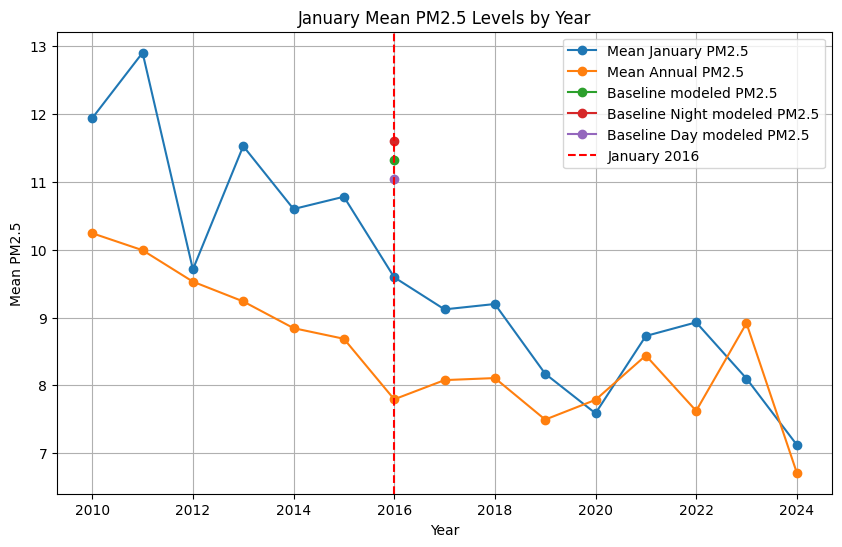

In [26]:
import matplotlib.pyplot as plt

# Plot the mean PM2.5 levels for January
plt.figure(figsize=(10, 6))
plt.plot(january_stats.index, january_stats['mean'], marker='o', label='Mean January PM2.5')
plt.plot(general_stats.index, general_stats['mean'], marker='o', label='Mean Annual PM2.5')
plt.plot(cmaq_baseline_stats.index, cmaq_baseline_stats['mean'], marker = 'o', label='Baseline modeled PM2.5')
plt.plot(cmaq_baseline_stats_night.index, cmaq_baseline_stats_night['mean'], marker = 'o', label='Baseline Night modeled PM2.5')
plt.plot(cmaq_baseline_stats_day.index, cmaq_baseline_stats_day['mean'], marker = 'o', label='Baseline Day modeled PM2.5')

# plt.plot(january_stats.index, january_stats['median'], marker='o', label='Median January PM2.5')
# plt.plot(general_stats.index, general_stats['median'], marker='o', label='Median Annual PM2.5')

# plt.plot(january_stats.index, january_stats['mean'], marker='o', label='Mean January PM2.5')
# plt.plot(general_stats.index, general_stats['mean'], marker='o', label='Mean Annual PM2.5')

plt.axvline(2016, color='red', linestyle='--', label='January 2016')
plt.title('January Mean PM2.5 Levels by Year')
plt.xlabel('Year')
plt.ylabel('Mean PM2.5')
plt.legend()
plt.grid(True)
plt.show()


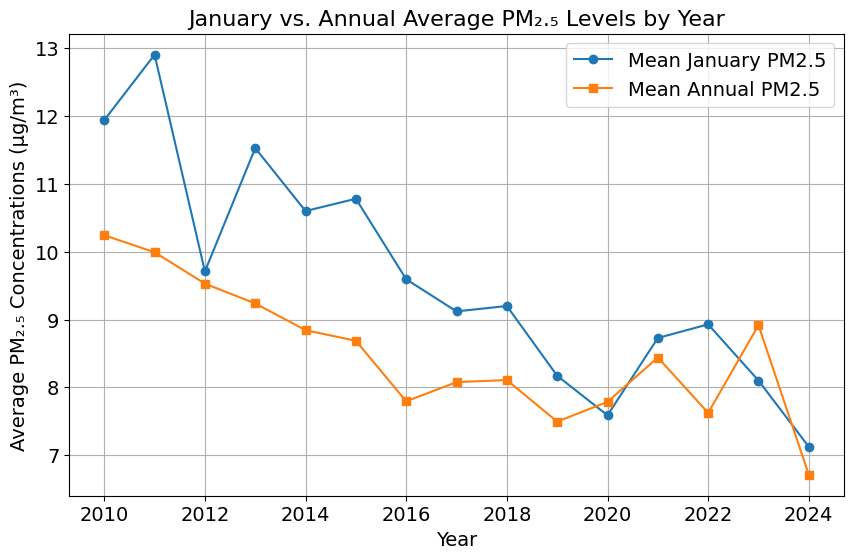

In [76]:
import matplotlib.pyplot as plt

# Plot the mean PM2.5 levels for January
plt.figure(figsize=(10, 6))
plt.plot(january_stats.index, january_stats['mean'], marker='o', label='Mean January PM2.5')
plt.plot(general_stats.index, general_stats['mean'], marker='s', label='Mean Annual PM2.5')
# plt.plot(cmaq_2020_stats.index, cmaq_2020_stats['mean'], marker = 'o', label='2020 modeled PM2.5')
# plt.plot(cmaq_2020_stats_night.index, cmaq_2020_stats_night['mean'], marker = 'o', label='2020 Night modeled PM2.5')

# plt.plot(cmaq_2020_stats_day.index, cmaq_2020_stats_day['mean'], marker = 'o', label='2020 Day modeled PM2.5')

# plt.plot(january_stats.index, january_stats['median'], marker='o', label='Median January PM2.5')
# plt.plot(general_stats.index, general_stats['median'], marker='o', label='Median Annual PM2.5')

# plt.plot(january_stats.index, january_stats['mean'], marker='o', label='Mean January PM2.5')
# plt.plot(general_stats.index, general_stats['mean'], marker='o', label='Mean Annual PM2.5')

#plt.axvline(2016, color='red', linestyle='--', label='January 2016')
plt.title('January vs. Annual Average PM₂.₅ Levels by Year',fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Average PM₂.₅ Concentrations (µg/m³)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()


In [39]:
df_cmaq_baseline_day['Year'] = "CMAQ_Baseline"
filtered_cmaq_2020['Year'] = "WRF-CMAQ"

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/3678927994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cmaq_baseline_day['Year'] = "CMAQ_Baseline"
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/3678927994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmaq_2020['Year'] = "WRF-CMAQ"


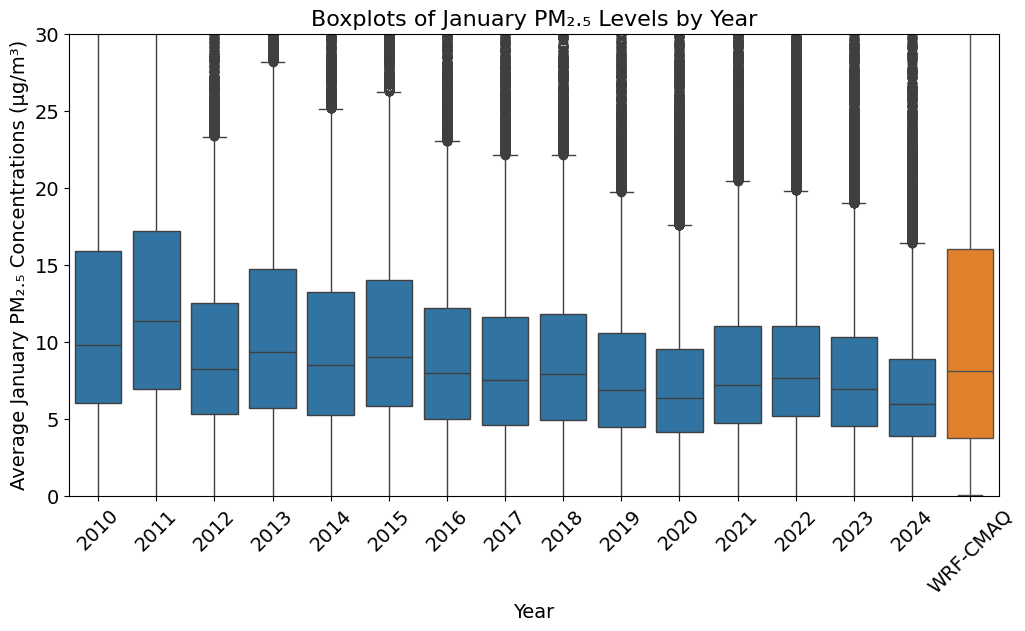

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the box plot
january_data_clean = january_data.dropna(subset=['Arithmetic Mean', 'Year'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Arithmetic Mean', data=january_data_clean)

#sns.boxplot(x='Year', y='CMAQ', data=df_cmaq_baseline_day)
sns.boxplot(x='Year', y='CMAQ', data=filtered_cmaq_2020)


#plt.axvline(2016, color='red', linestyle='--', label='January 2016')
plt.title('Boxplots of January PM₂.₅ Levels by Year', fontsize = 16)
plt.ylabel('Average January PM₂.₅ Concentrations (µg/m³)', fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.ylim([0,30])
plt.xticks(rotation=45, fontsize = 14)  # Rotate x-axis labels for readability
plt.yticks(fontsize = 14) 
plt.show()


In [43]:
# Filter data for Winter months (December, January, February)
winter_data = filtered_data[filtered_data['Date Local'].dt.month.isin([12, 1, 2])]

# Add a column for the month name (optional, for clearer plotting)
winter_data['Month'] = winter_data['Date Local'].dt.month_name()

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/2099534161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_data['Month'] = winter_data['Date Local'].dt.month_name()


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_52376/2335723727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmaq_2020['Year'] = "WRF-CMAQ"
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


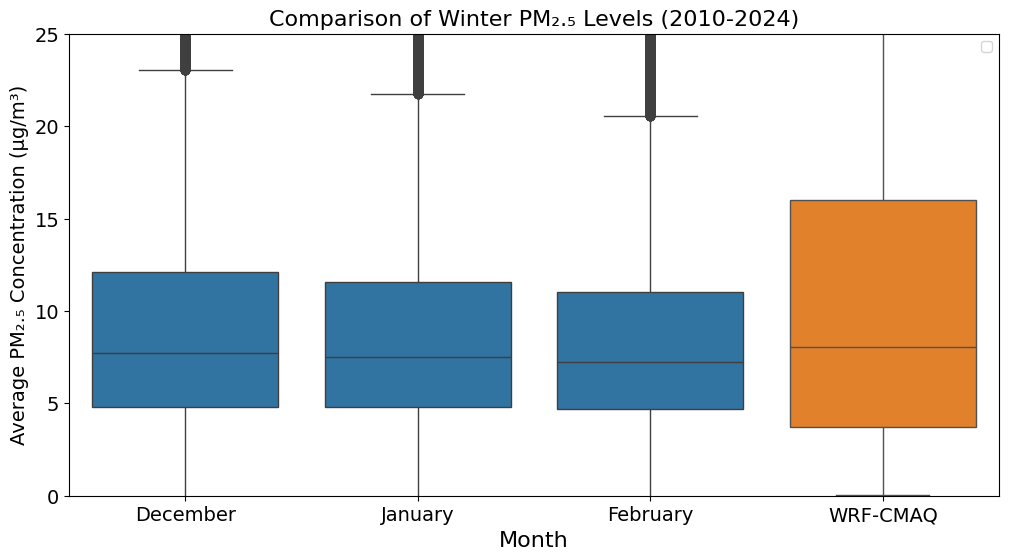

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
filtered_cmaq_2020['Year'] = "WRF-CMAQ"
# Create the box plot comparing PM2.5 levels in December, January, and February
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Arithmetic Mean', data=winter_data, order=['December', 'January', 'February'])
sns.boxplot(x='Year', y='CMAQ', data=filtered_cmaq_2020)
#sns.boxplot(x='Year', y='CMAQ', data=df_day_2020)

#plt.axvline('January', color='red', linestyle='--', label='January')
plt.title('Comparison of Winter PM₂.₅ Levels (2010-2024)', fontsize = 16)
plt.ylabel('Average PM₂.₅ Concentration (µg/m³)', fontsize= 14)
plt.xlabel('Month', fontsize = 16)
plt.ylim([0,25])
plt.xticks(fontsize = 14) 
plt.yticks(fontsize = 14) 

plt.legend()
plt.show()

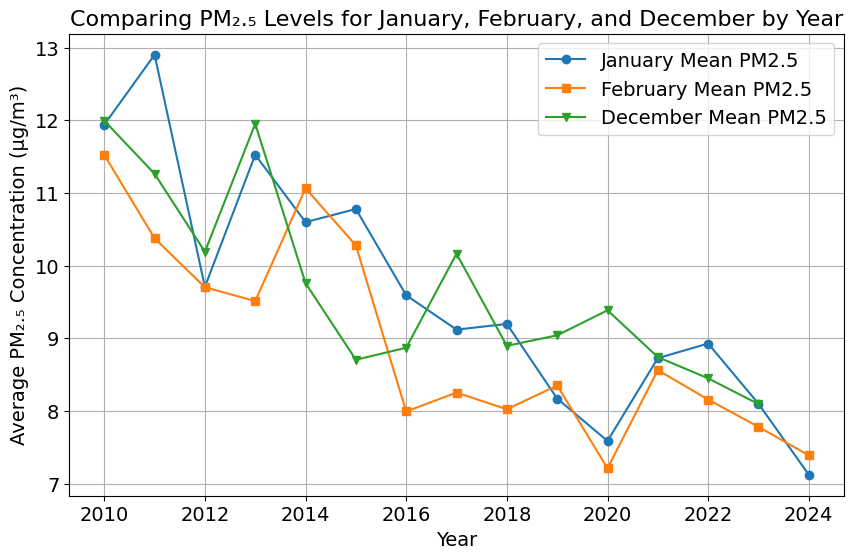

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the mean PM2.5 by year and month
monthly_stats = winter_data.groupby(['Year', 'Month'])['Arithmetic Mean'].mean().unstack()

# Plot the mean PM2.5 levels for January, February, and December
plt.figure(figsize=(10, 6))
plt.plot(monthly_stats.index, monthly_stats['January'], marker='o', label='January')
plt.plot(monthly_stats.index, monthly_stats['February'], marker='s', label='February')
plt.plot(monthly_stats.index, monthly_stats['December'], marker='v', label='December')
# plt.plot(cmaq_baseline_stats_night.index, cmaq_baseline_stats_night['mean'], marker = 'o', label='Baseline Night modeled PM2.5')
# plt.plot(cmaq_baseline_stats_day.index, cmaq_baseline_stats_day['mean'], marker = 'o', label='Baseline Day modeled PM2.5')

# Highlight January 2016 with a vertical line
#plt.axvline(2016, color='red', linestyle='--', label='January 2016')

plt.title('Comparing PM₂.₅ Levels for January, February, and December by Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Average PM₂.₅ Concentration (µg/m³)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14 )
plt.grid(True)
plt.show()


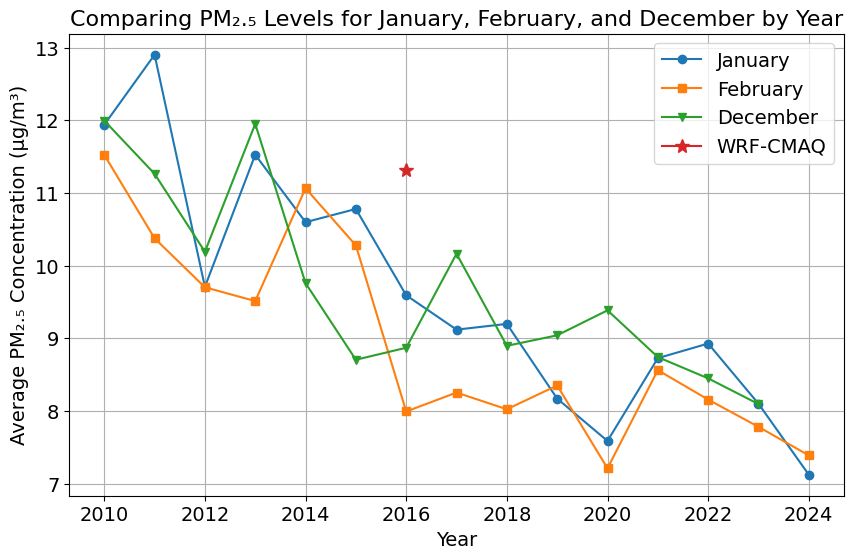

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the mean PM2.5 by year and month
monthly_stats = winter_data.groupby(['Year', 'Month'])['Arithmetic Mean'].mean().unstack()

# Plot the mean PM2.5 levels for January, February, and December
plt.figure(figsize=(10, 6))
plt.plot(monthly_stats.index, monthly_stats['January'], marker='o', label='January')
plt.plot(monthly_stats.index, monthly_stats['February'], marker='s', label='February')
plt.plot(monthly_stats.index, monthly_stats['December'], marker='v', label='December')
plt.plot(cmaq_baseline_stats.index, cmaq_baseline_stats['mean'], marker = '*', markersize = 10, label='WRF-CMAQ')
# plt.plot(cmaq_baseline_stats_night.index, cmaq_baseline_stats_night['mean'], marker = 'o', label='Baseline Night modeled PM2.5')
# plt.plot(cmaq_baseline_stats_day.index, cmaq_baseline_stats_day['mean'], marker = 'o', label='Baseline Day modeled PM2.5')

# Highlight January 2016 with a vertical line
#plt.axvline(2016, color='red', linestyle='--', label='January 2016')

plt.title('Comparing PM₂.₅ Levels for January, February, and December by Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Average PM₂.₅ Concentration (µg/m³)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14 )
plt.grid(True)
plt.show()
